# Wind Power Prediction by LSTM RNN

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preperation
### Get data from csv file

In [2]:
def get_data(csv_path):
    data = pd.read_csv(csv_path, header=None)
    npdata = data.values
    return npdata

path_power = "power_output_jz.csv"
data_power = get_data(path_power)
print("Power data shape is", data_power.shape)
print(data_power)

path_wind = "wind_output_jz.csv"
data_wind = get_data(path_wind)
print("Wind data shape is", data_wind.shape)
print(data_wind)

path_direc = "direc_output.csv"
data_direc = get_data(path_direc)
print("Wind direction data shape is", data_direc.shape)

Power data shape is (366, 48)
[[   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 ..., 
 [  46.40000153   79.90000153  104.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.           10.        ]
 [  35.29999924  149.1000061     0.         ...,    0.            0.            0.        ]]
Wind data shape is (366, 48)
[[ 0.32879275  2.81207657  4.57900095 ...,  1.65955198  0.06527802
   0.88392872]
 [ 0.93698859  2.35590959  0.8299045  ...,  0.          1.14228976
   0.66118342]
 [ 0.61035281  2.35925364  2.13929534 ...,  2.90369177  2.2120142
   1.85126662]
 ..., 
 [ 4.64423084  6.4978838   7.48124266 ...,  8.56146812  5.30285883
   6.72797442]
 [ 7.18974781  8.01025677  7.1524787  ...,  1.2

### Data cleaning

In [3]:
def clean_nan(data):
    print("NaN value found in these location:")
    nan_idx = np.argwhere(np.isnan(data))
    print(nan_idx)

    # If there are some NaN values
    if len(nan_idx != 0):
        print(data[nan_idx[0][0], nan_idx[0][1]])
        for idx in nan_idx:
            assert(np.isnan(data[idx[0], idx[1]]))
            assert(~np.isnan(data[idx[0], idx[1]-1]))
            assert(~np.isnan(data[idx[0], idx[1]+1]))
            data[idx[0], idx[1]] = np.average([data[idx[0], idx[1]-1], 
                                               data[idx[0], idx[1]+1]]) 
        print(data[nan_idx[0][0], nan_idx[0][1]])
        print(data[nan_idx[1][0], nan_idx[1][1]])
    return data

data_power_clean = clean_nan(data_power)
data_wind_clean = clean_nan(data_wind)
data_direc_clean = clean_nan(data_direc)
print("After cleaning, Nan location:")
print("Power NaN: ", np.argwhere(np.isnan(data_power_clean)))
print("Wind NaN: ", np.argwhere(np.isnan(data_wind_clean)))
print("Direction NaN: ", np.argwhere(np.isnan(data_direc_clean)))

NaN value found in these location:
[]
NaN value found in these location:
[[223  27]
 [237  31]]
nan
1.107337594
3.6171355245
NaN value found in these location:
[]
After cleaning, Nan location:
Power NaN:  []
Wind NaN:  []
Direction NaN:  []


### Data normalization

In [4]:
def flatten(data):
    return data.flatten()

data_power_flatten = flatten(data_power_clean)
data_wind_flatten = flatten(data_wind_clean)
data_direc_flatten = flatten(data_direc_clean)
print(np.shape(data_power_flatten))
print(np.shape(data_wind_flatten))
print(np.shape(data_direc_flatten))

(17568,)
(17568,)
(17568,)


In [5]:
# Create Switch feature
data_switch_flatten = np.zeros(17568)
zero_tuple = np.nonzero(data_power_flatten)
new_indices = zero_tuple[0] - 1
data_switch_flatten[new_indices] = 1
print(data_switch_flatten[210:250])

[ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.
  0.  0.  0.  0.]


In [6]:
def normalize(data):
    assert(len(np.shape(data)) == 1), \
    "Data pass in normalize() must be flattened!"
    
    max_val = data.max()
    print('Max value =', max_val)
    data_n = data / max_val
    return data_n, max_val

data_power_normalize, power_max_val = normalize(data_power_flatten) 
data_wind_normalize, wind_max_val = normalize(data_wind_flatten)
data_direc_normalize, direc_max_val = normalize(data_direc_flatten)

print(data_power_normalize)
print("Max:", data_power_normalize.max())
print("Min:", data_power_normalize.min())
print(data_wind_normalize)
print("Max:", data_wind_normalize.max())
print("Min:", data_wind_normalize.min())
print(data_direc_normalize)
print("Max:", data_direc_normalize.max())
print("Min:", data_direc_normalize.min())

Max value = 1589.0
Max value = 26.47499275
Max value = 1.0
[ 0.  0.  0. ...,  0.  0.  0.]
Max: 1.0
Min: -0.0629326620516
[ 0.01241899  0.10621633  0.1729557  ...,  0.10034923  0.01244154
  0.07997919]
Max: 1.0
Min: -0.000196968703608
[ 0.  0.  0. ...,  1.  1.  1.]
Max: 1.0
Min: 0.0


### Visualize input data

(array([ 1.11544514,  0.66016141,  0.70568978,  0.76260025,  0.96747793,
         0.99024211,  1.22926607,  1.75284236,  1.59349305,  2.11706934,
         2.03739469,  2.12845144,  2.23089027,  2.33332911,  2.43576795,
         2.99349052,  2.48129633,  2.65202772,  2.67479191,  3.08454727,
         3.1983682 ,  2.92519796,  3.09592936,  3.06178308,  2.91381587,
         2.67479191,  3.06178308,  2.76584866,  2.72032028,  2.43576795,
         2.49267842,  2.59511726,  2.99349052,  2.44715005,  2.6975561 ,
         2.8682875 ,  2.5268247 ,  2.64064563,  2.44715005,  2.54958889,
         2.56097098,  2.67479191,  2.44715005,  2.20812609,  2.53820679,
         2.34471121,  2.17397981,  2.36747539,  2.00324841,  2.23089027,
         2.49267842,  2.13983353,  2.15121562,  2.03739469,  1.8438991 ,
         2.10568725,  1.98048422,  1.60487515,  2.07154097,  1.54796468,
         1.55934677,  1.77560655,  1.74146027,  1.59349305,  1.66178561,
         1.5138184 ,  1.47967212,  1.65040352,  1.8

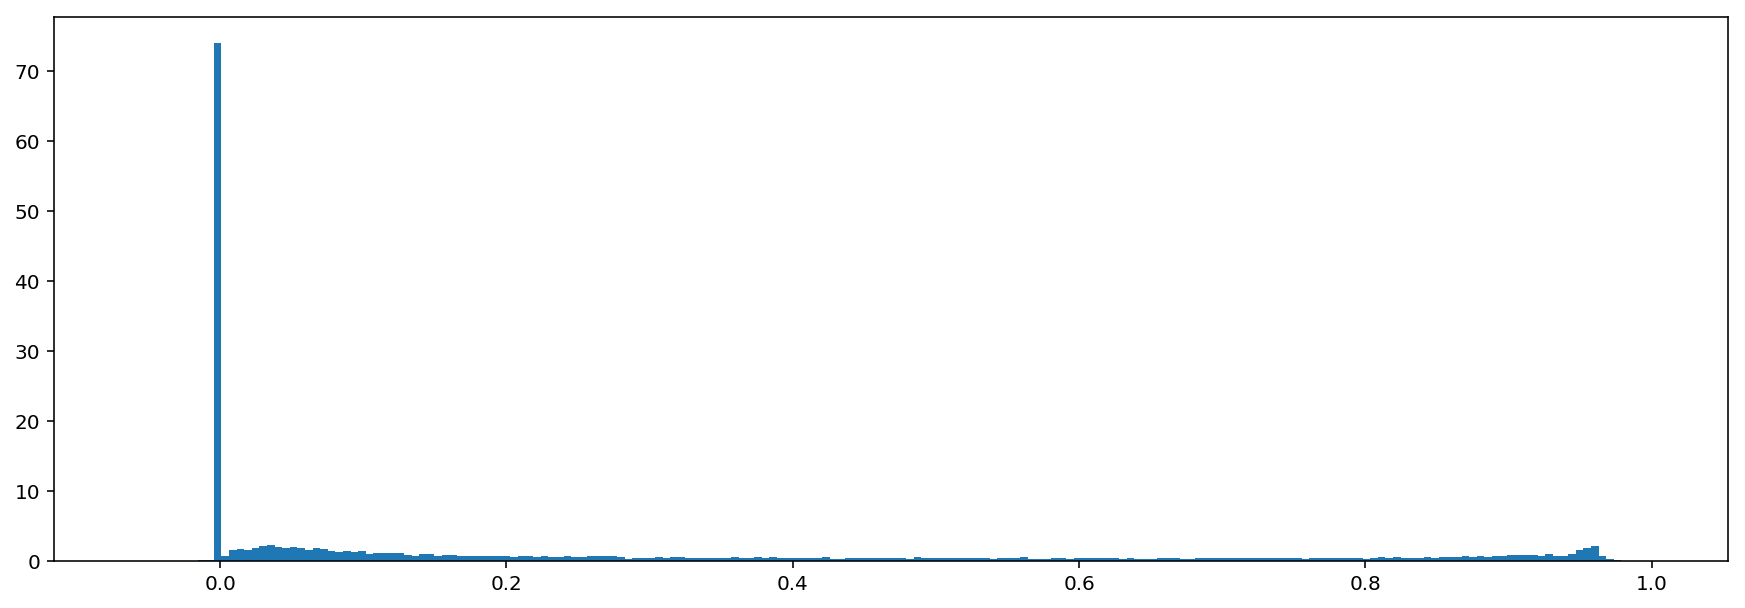

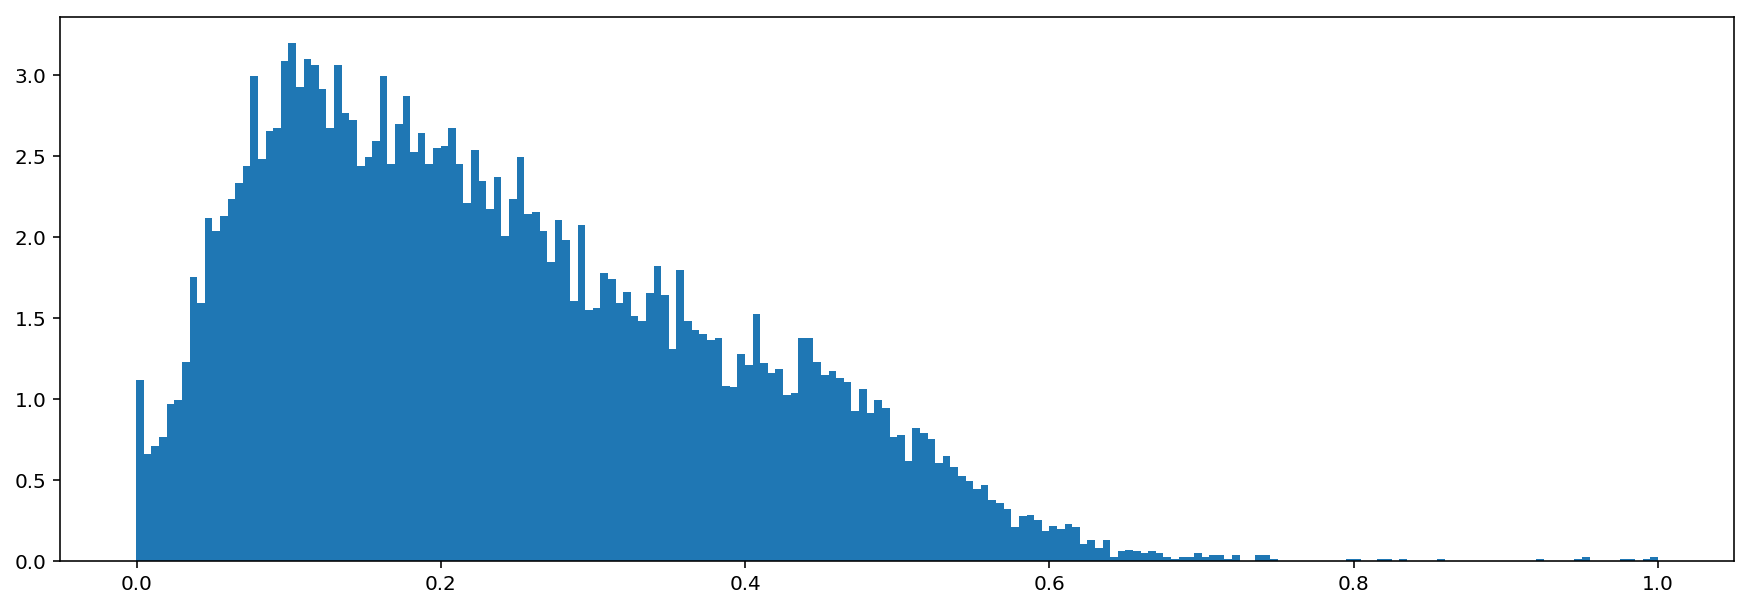

In [7]:
# plt.hist(data_power_normalize, bins = 300, normed=True)
# plt.show()

_, ax = plt.subplots(figsize=(15,5))
ax.hist(data_power_normalize, bins=200, normed=True)
_, bx = plt.subplots(figsize=(15,5))
bx.hist(data_wind_normalize, bins=200, normed=True)

### Prepare batches

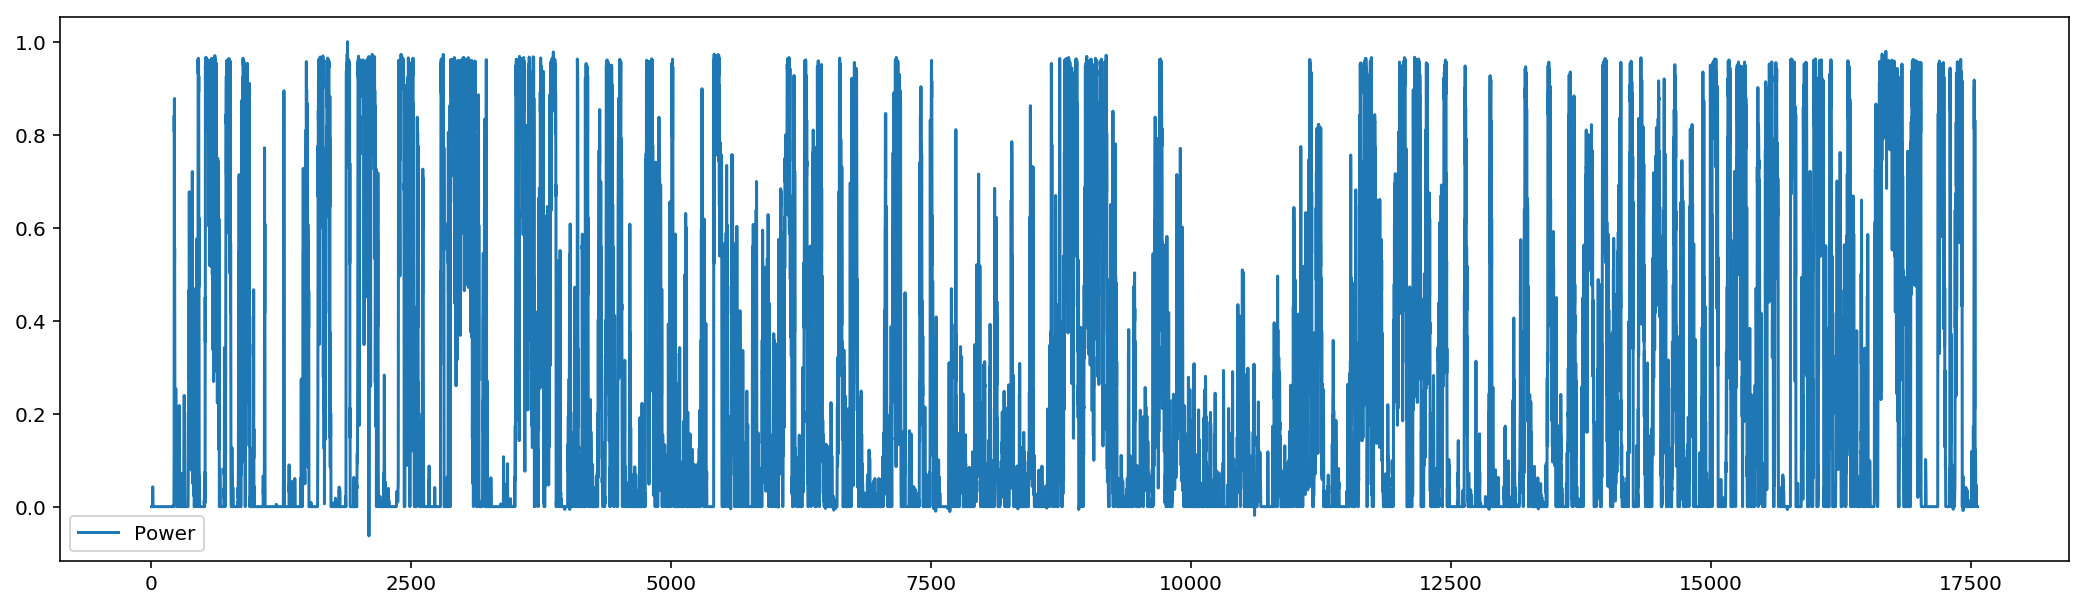

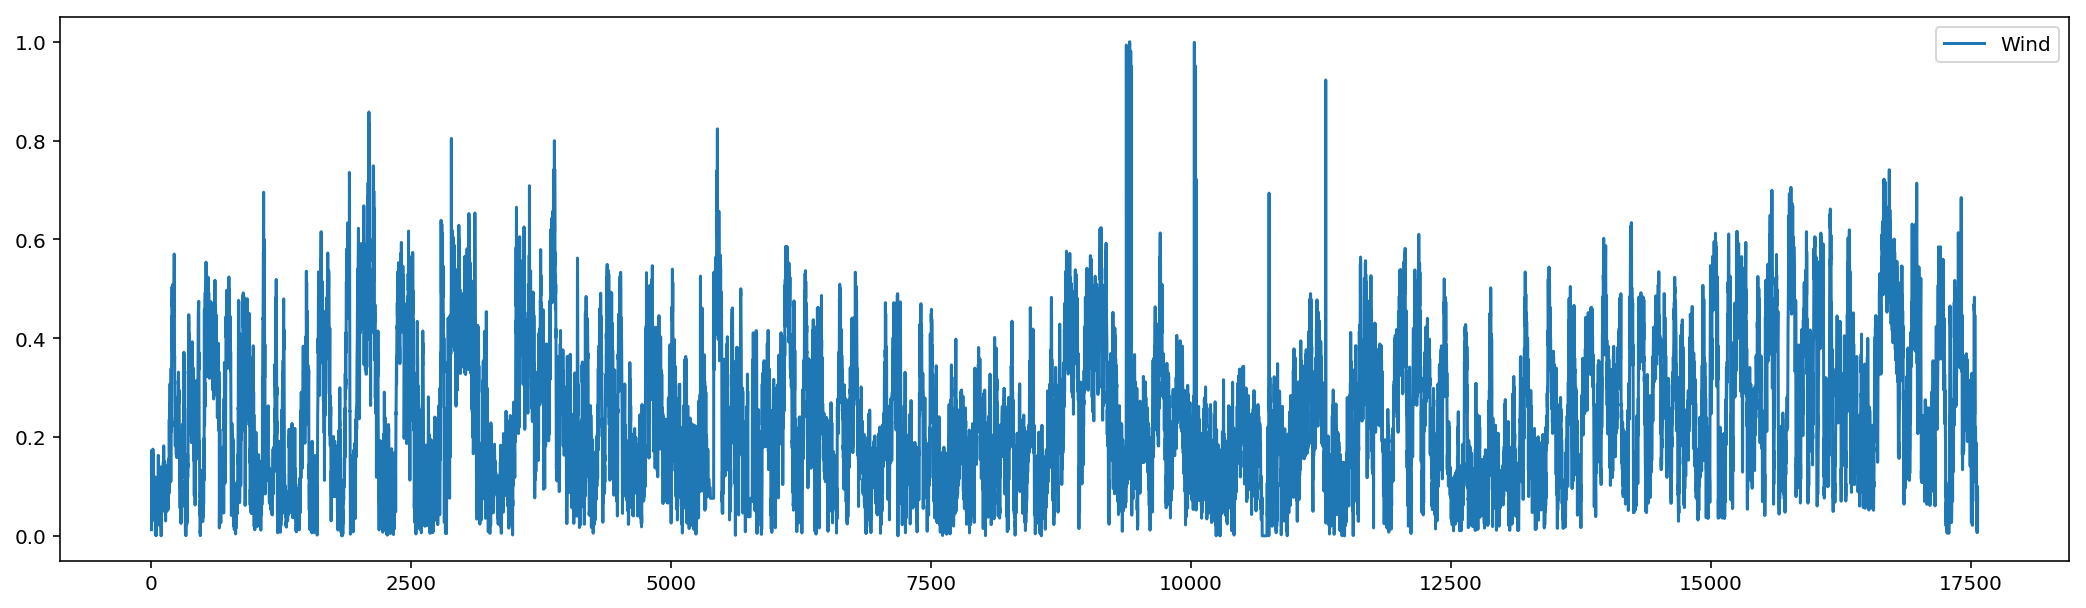

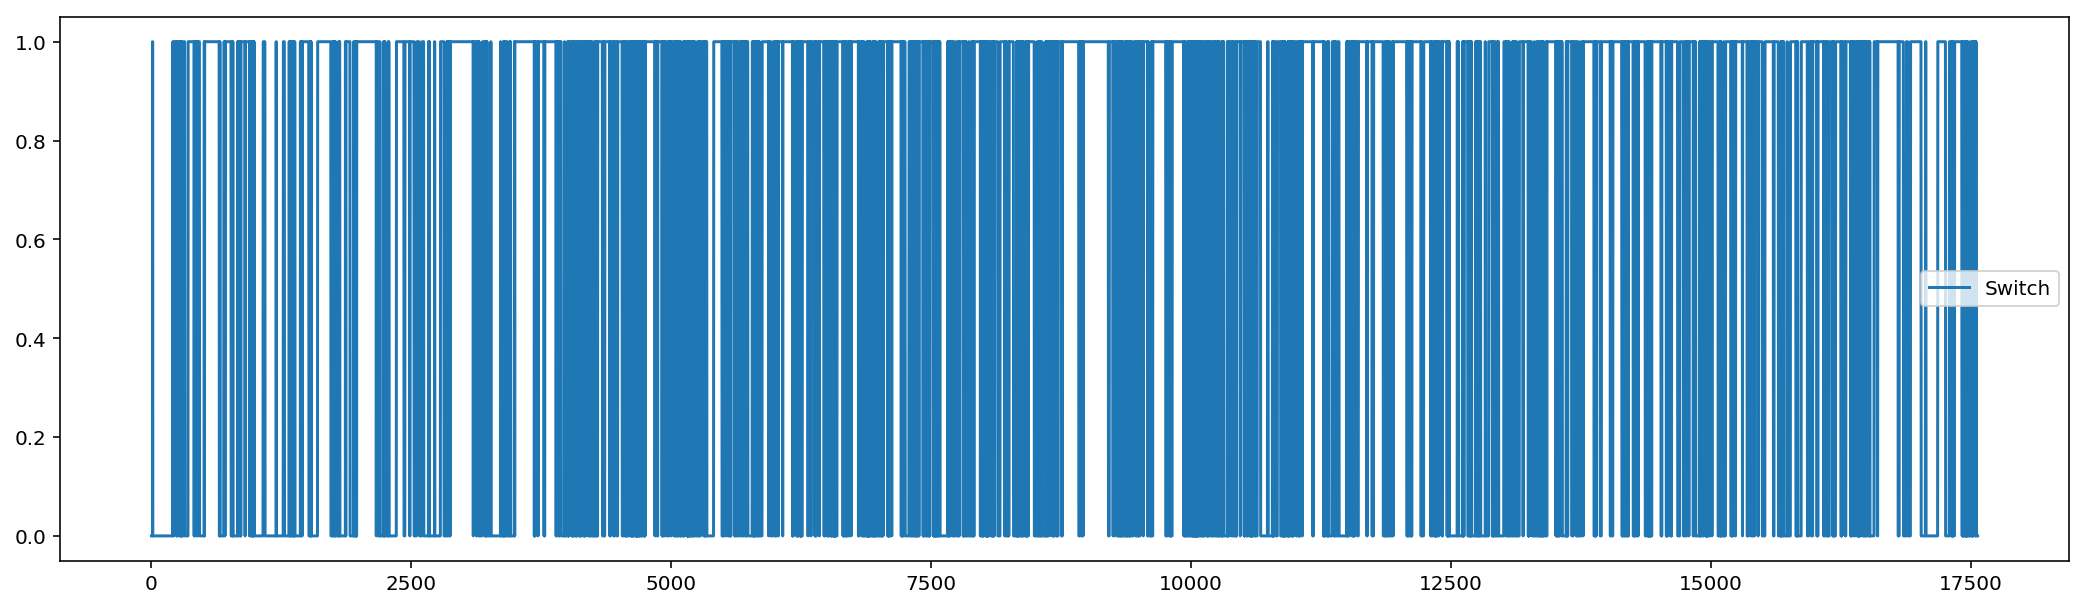

In [8]:
_, ax = plt.subplots(figsize=(18,5))
ax.plot(data_power_normalize, label="Power")
ax.legend()

_, bx = plt.subplots(figsize=(18,5))
bx.plot(data_wind_normalize, label="Wind")
bx.legend()

_, cx = plt.subplots(figsize=(18,5))
cx.plot(data_switch_flatten, label="Switch")
cx.legend()

In [9]:
def load_data(data, window, features):
    seq_len = window + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index+seq_len])
    
    result = np.array(result)
#     print(np.shape(result))
    train_rows = round(0.9 * result.shape[0])
    train = result[:int(train_rows), :]
    print("Train", np.shape(train))

    x_train = train[:, :-1]
    print("x_train", np.shape(x_train))
    print(x_train[200:210, -1, 0])
    
    y_train = train[:, -1][:, 0]
    print("y_train", np.shape(y_train))
    print(y_train[200:210])
    
    x_test = result[int(train_rows):, :-1]
#     print("x_test", np.shape(x_test))
    
    y_test = result[int(train_rows):, -1][:, 0]
#     print("y_test", np.shape(y_test))
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], features))
    
    return [x_train, y_train, x_test, y_test]
 

# Prepare data
feed_data = np.column_stack((data_power_normalize, data_wind_normalize, data_direc_normalize))
features = np.shape(feed_data)[1]

window = 16
x_train, y_train, x_test, y_test = load_data(feed_data, window, features)
# test = [[[11,12,13],[14,15,16],[17,18,19]],[[21,22,23],[24,25,26],[27,28,29]]]
# test = np.array(test)
# print(feed_data)
# print(test)
# print(test[:, -1][:, 0])

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)


Train (15796, 17, 3)
x_train (15796, 16, 3)
[ 0.          0.          0.04090623  0.11044682  0.84140969  0.80547516
  0.87784772  0.52473253  0.55607299  0.36696034]
y_train (15796,)
[ 0.          0.04090623  0.11044682  0.84140969  0.80547516  0.87784772
  0.52473253  0.55607299  0.36696034  0.26268093]
x_train (15796, 16, 3)
y_train (15796,)
x_test (1755, 16, 3)
y_test (1755,)


## Building model

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import time

def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences=True))
    model.add(Dropout(0.7))
    
    model.add(Dense(
        output_dim=5))
    model.add(Activation("sigmoid"))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(1.0))
    
    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss='mse', optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

Using TensorFlow backend.


In [11]:
model = build_model([features, window, 1])

/Users/JFrmbp/Support/anaconda3/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/JFrmbp/Support/anaconda3/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=16, return_sequences=True, input_shape=(None, 3))`
/Users/JFrmbp/Support/anaconda3/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=5)`


Compilation Time :  0.03814387321472168


/Users/JFrmbp/Support/anaconda3/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


## Executing the model & RMS/RMSE results

In [21]:
model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=200,
    validation_split=0.2,
    verbose=1)

/Users/JFrmbp/Support/anaconda3/envs/tflearn/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 12636 samples, validate on 3160 samples
Epoch 1/200
12636/12636 [==============================] - 3s - loss: 0.0183 - acc: 0.4026 - val_loss: 0.0138 - val_acc: 0.3604

KeyboardInterrupt: 

In [13]:
import math

trainScore = model.evaluate(x_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(x_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

1696/1755 [===========================>..] - ETA: 0sTest Score: 0.02 MSE (0.14 RMSE)


In [14]:
diff = []
ratio = []
p = model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]-pr))
    print(u, y_test[u]*power_max_val,'\t', pr*power_max_val,'\t', (y_test[u]/pr)-1, '\t', abs(y_test[u]- pr)*power_max_val)

0 722.2999878 	 855.350424767 	 -0.155550793118 	 133.050436967
1 993.2999878 	 774.677629381 	 0.282210754676 	 218.622358419
2 1366.0 	 935.468919456 	 0.460230234901 	 430.531080544
3 961.2000122 	 1187.78176582 	 -0.190760424296 	 226.581753619
4 786.9000244 	 1178.12646806 	 -0.332075082148 	 391.226443662
5 1341.400024 	 1021.85117775 	 0.312715641187 	 319.548846248
6 495.1000061 	 1195.45701909 	 -0.585848760605 	 700.357012991
7 0.0 	 937.659887075 	 -1.0 	 937.659887075
8 0.0 	 339.469184041 	 -1.0 	 339.469184041
9 0.0 	 54.9508220367 	 -1.0 	 54.9508220367
10 0.0 	 20.6908376897 	 -1.0 	 20.6908376897
11 0.0 	 20.6908376897 	 -1.0 	 20.6908376897
12 0.0 	 20.6908376897 	 -1.0 	 20.6908376897
13 0.0 	 20.6908376897 	 -1.0 	 20.6908376897
14 0.0 	 20.6908376897 	 -1.0 	 20.6908376897
15 46.20000076 	 20.6908376897 	 1.23287241691 	 25.5091630703
16 14.10000038 	 27.2182389367 	 -0.481965001014 	 13.1182385567
17 12.89999962 	 20.6908376897 	 -0.376535652472 	 7.79083806968
18

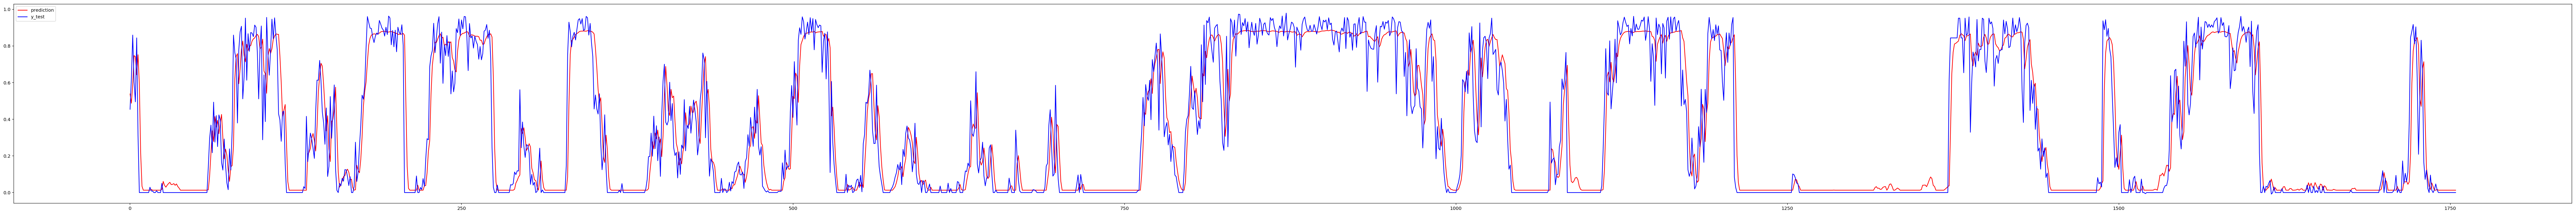

In [20]:
_, ax = plt.subplots(figsize=(100,8))
ax.plot(p,color='red', label='prediction')
ax.plot(y_test,color='blue', label='y_test')
ax.legend(loc='upper left')